## Dependencies

In [1]:
import json
from tweet_utility_scripts import *
from transformers import TFDistilBertModel, DistilBertConfig
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-distilbert-uncased-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-96/fold_1.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-96/fold_2.tar.gz
!tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-96/fold_3.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-96/fold_4.tar.gz
# !tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13,train,train,validation,train,train


fold_1/
fold_1/x_valid.npy
fold_1/y_train.npy
fold_1/x_train.npy
fold_1/y_valid.npy
fold_2/
fold_2/x_valid.npy
fold_2/y_train.npy
fold_2/x_train.npy
fold_2/y_valid.npy
fold_3/
fold_3/x_valid.npy
fold_3/y_train.npy
fold_3/x_train.npy
fold_3/y_valid.npy


# Model parameters

In [3]:
tokenizer_path = database_base_path + 'vocab.txt'
base_path = '/kaggle/input/qa-transformers/distilbert/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 16,
  "EPOCHS": 5,
  "LEARNING_RATE": 5e-5,
  "ES_PATIENCE": 1,
  "question_size": 3,
  "N_FOLDS": 3,
  "base_model_path": base_path + 'distilbert-base-uncased-distilled-squad-tf_model.h5',
  "config_path": base_path + 'distilbert-base-uncased-distilled-squad-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [4]:
module_config = DistilBertConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFDistilBertModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    last_state = sequence_output[0]
    
    x_start = tf.keras.layers.Conv1D(1,1)(last_state)
    x_start = tf.keras.layers.Flatten()(x_start)
    y_start = Dense(1, activation='linear', name='y_start')(x_start)   

    x_end = tf.keras.layers.Conv1D(1,1)(last_state)
    x_end = tf.keras.layers.Flatten()(x_end)
    y_end = Dense(1, activation='linear', name='y_end')(x_end)        
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.MeanSquaredError(), 
                  metrics=[metrics.MeanSquaredError()])
    
    return model

# Tokenizer

In [5]:
tokenizer = BertWordPieceTokenizer(tokenizer_path , lowercase=True)
tokenizer.save('./')

['./vocab.txt']

# Train

In [6]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy').argmax(axis=-1)
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy').argmax(axis=-1)

    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    model = model_fn(config['MAX_LEN'])
    tb_callback = TensorBoard(log_dir='./')
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)

    history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[es, tb_callback],
                    epochs=config['EPOCHS'], 
                    batch_size=config['BATCH_SIZE'],
                    verbose=1).history
    history_list.append(history)

    # Save last epoch weights
    model.save_weights(model_path)
    
    # Make predictions
    train_preds = model.predict(list(x_train))
    valid_preds = model.predict(list(x_valid))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'start_fold_%d' % (n_fold+1)] = train_preds[0].astype(int)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'end_fold_%d' % (n_fold+1)] = train_preds[1].astype(int)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'start_fold_%d' % (n_fold+1)] = valid_preds[0].astype(int)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'end_fold_%d' % (n_fold+1)] = valid_preds[1].astype(int)
    
    k_fold['end_fold_%d' % (n_fold+1)] = k_fold['end_fold_%d' % (n_fold+1)].astype(int)
    k_fold['start_fold_%d' % (n_fold+1)] = k_fold['start_fold_%d' % (n_fold+1)].astype(int)
    k_fold['end_fold_%d' % (n_fold+1)].clip(0, k_fold['text_len'], inplace=True)
    k_fold['start_fold_%d' % (n_fold+1)].clip(0, k_fold['end_fold_%d' % (n_fold+1)], inplace=True)
    k_fold['prediction_fold_%d' % (n_fold+1)] = k_fold.apply(lambda x: decode(x['start_fold_%d' % (n_fold+1)], x['end_fold_%d' % (n_fold+1)], x['text'], config['question_size'], tokenizer), axis=1)
    k_fold['prediction_fold_%d' % (n_fold+1)].fillna('', inplace=True)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 [==============================] - 164s 7ms/sample - loss: 54.9471 - y_start_loss: 24.4839 - y_end_loss: 30.4632 - y_start_mean_squared_error: 24.4839 - y_end_mean_squared_error: 30.4632 - val_loss: 38.3103 - val_y_start_loss: 16.8216 - val_y_end_loss: 21.4446 - val_y_start_mean_squared_error: 16.8399 - val_y_end_mean_squared_error: 21.4704
Epoch 2/5
21984/21984 [==============================] - 153s 7ms/sample - loss: 33.4537 - y_start_loss: 15.3623 - y_end_loss: 18.0915 - y_start_mean_squared_error: 15.3623 - y_end_mean_squared_error: 18.0915 - val_loss: 38.4563 - val_y_start_loss: 16.3231 - val_y_end_loss: 22.0903 - val_y_start_mean_squared_error: 16.3427 - val_y_end_mean_squared_error: 22.1136
Epoch 00002: early stopping

FOLD: 2
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 [==============================] - 160s 7ms/sample - loss: 52.4526 - y_start_loss: 22.8564 - y_end_loss:

In [7]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1586993995.93ec7a4cff5c.12.128747.v2
train/events.out.tfevents.1586993469.93ec7a4cff5c.12.59038.v2
train/events.out.tfevents.1586993090.93ec7a4cff5c.12.5448.v2
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-15_23-31-15/
train/plugins/profile/2020-04-15_23-31-15/local.trace
train/plugins/profile/2020-04-15_23-40-01/
train/plugins/profile/2020-04-15_23-40-01/local.trace
train/plugins/profile/2020-04-15_23-25-00/
train/plugins/profile/2020-04-15_23-25-00/local.trace
train/events.out.tfevents.1586993100.93ec7a4cff5c.profile-empty
validation/
validation/events.out.tfevents.1586993254.93ec7a4cff5c.12.32555.v2
validation/events.out.tfevents.1586994155.93ec7a4cff5c.12.155854.v2
validation/events.out.tfevents.1586993629.93ec7a4cff5c.12.86145.v2


# Model loss graph

Fold: 1


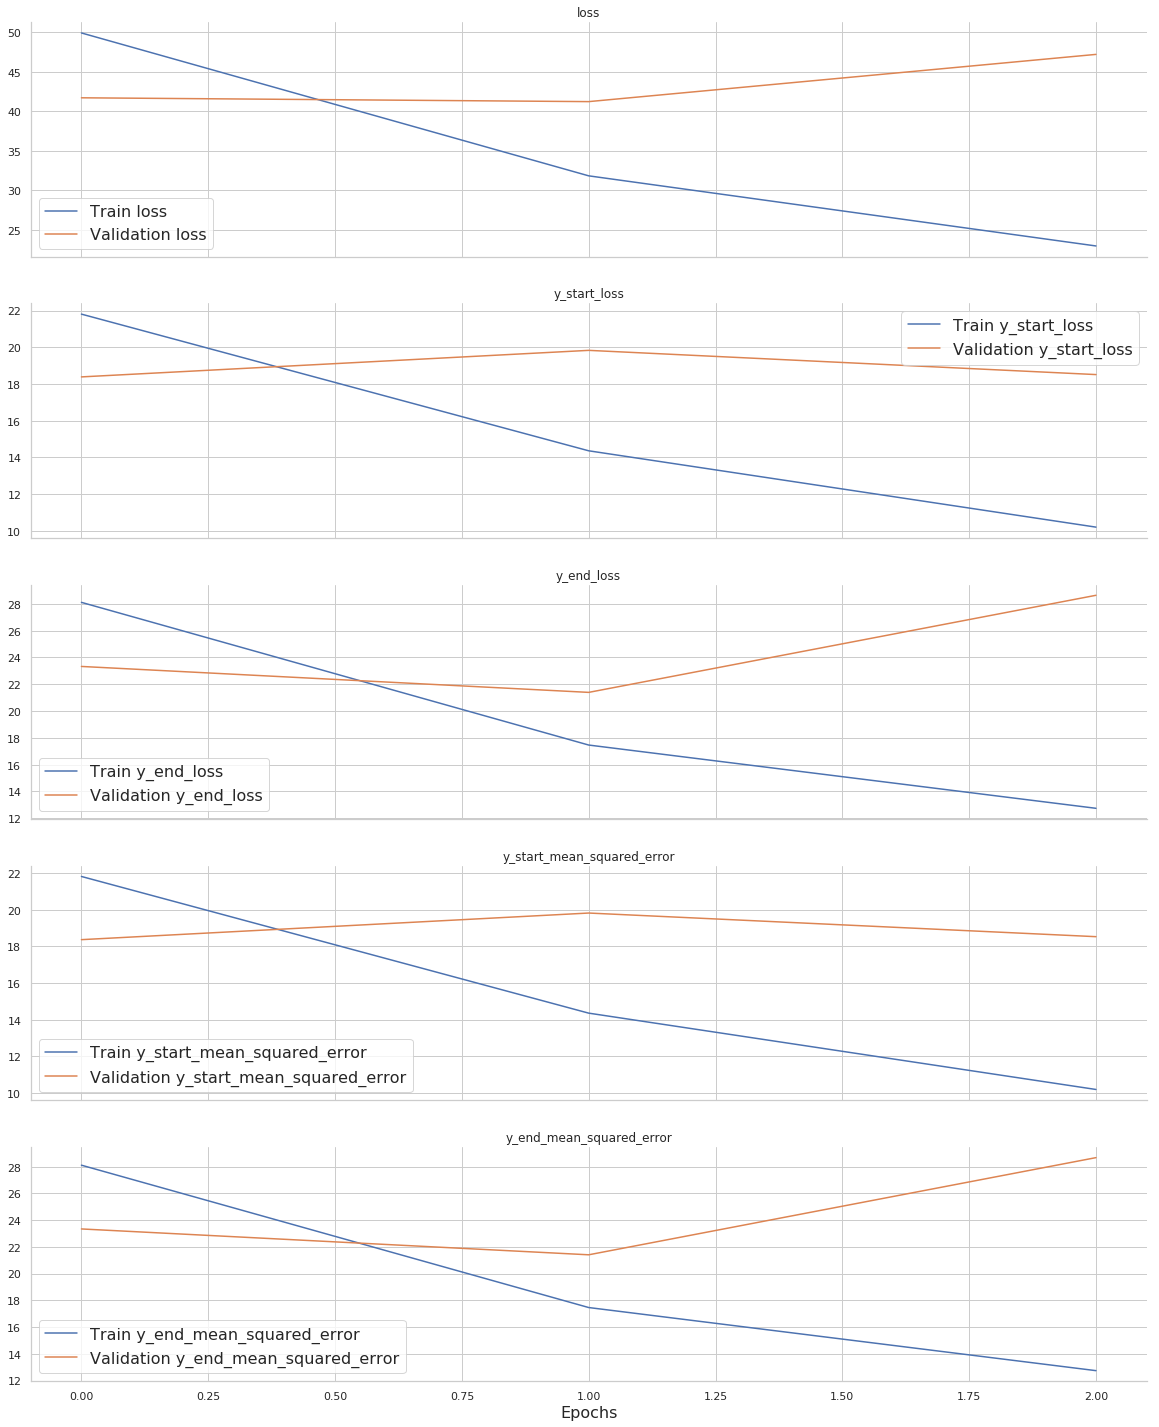

Fold: 2


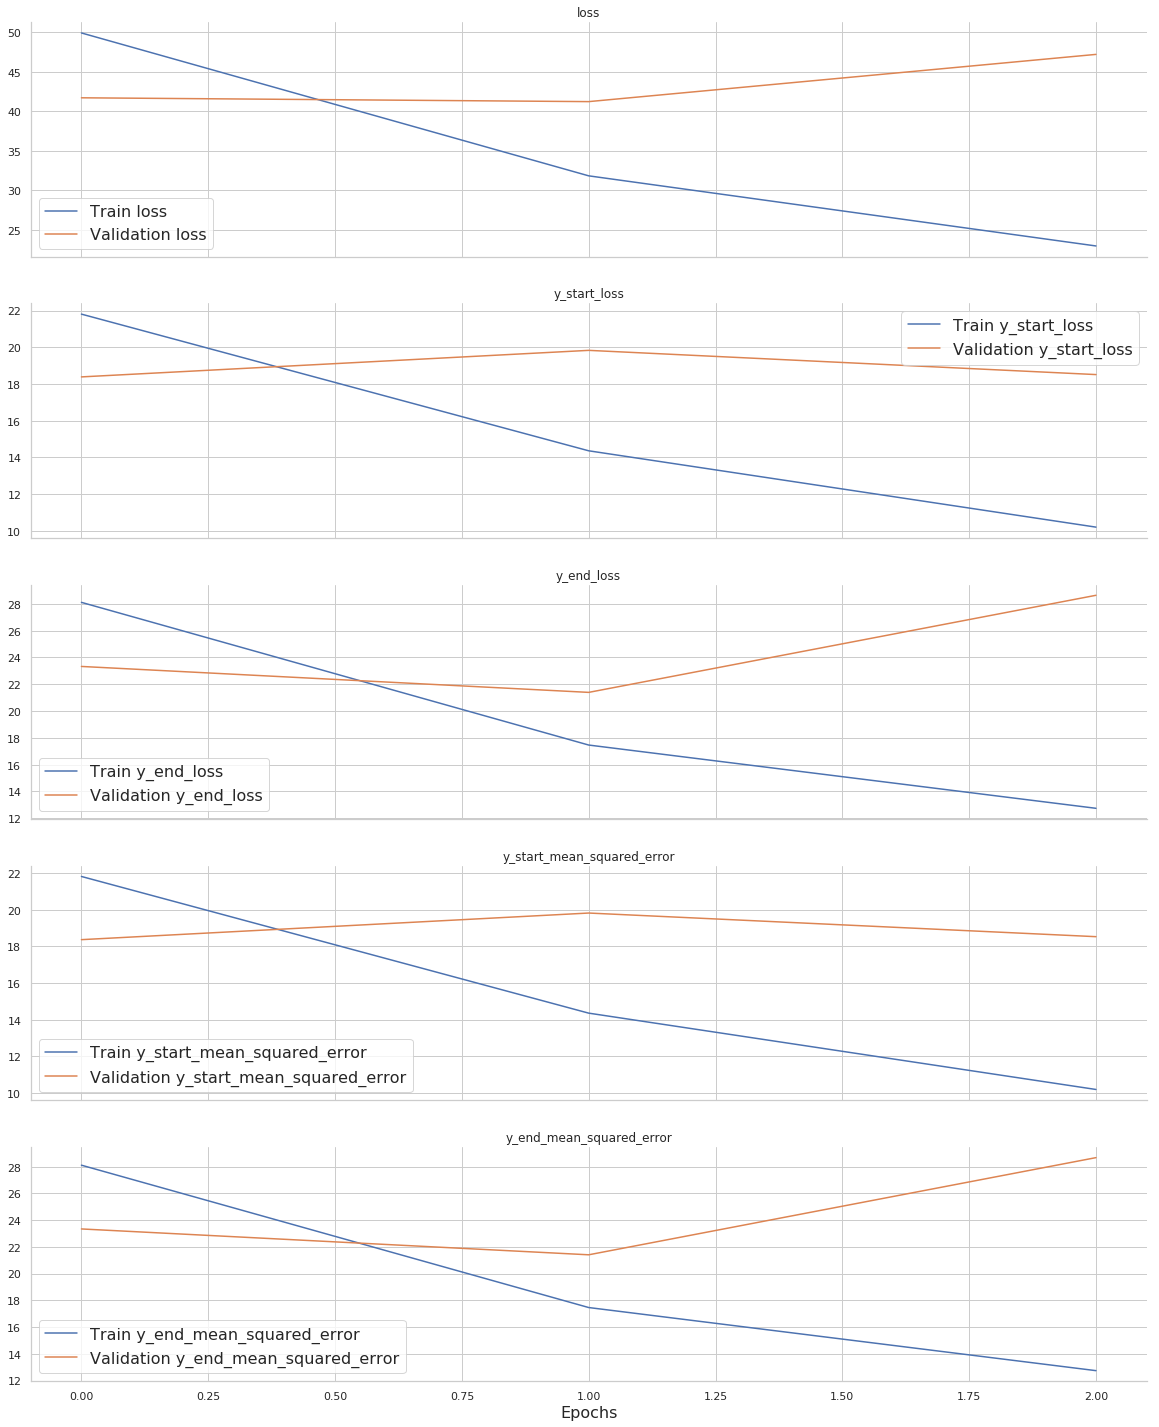

Fold: 3


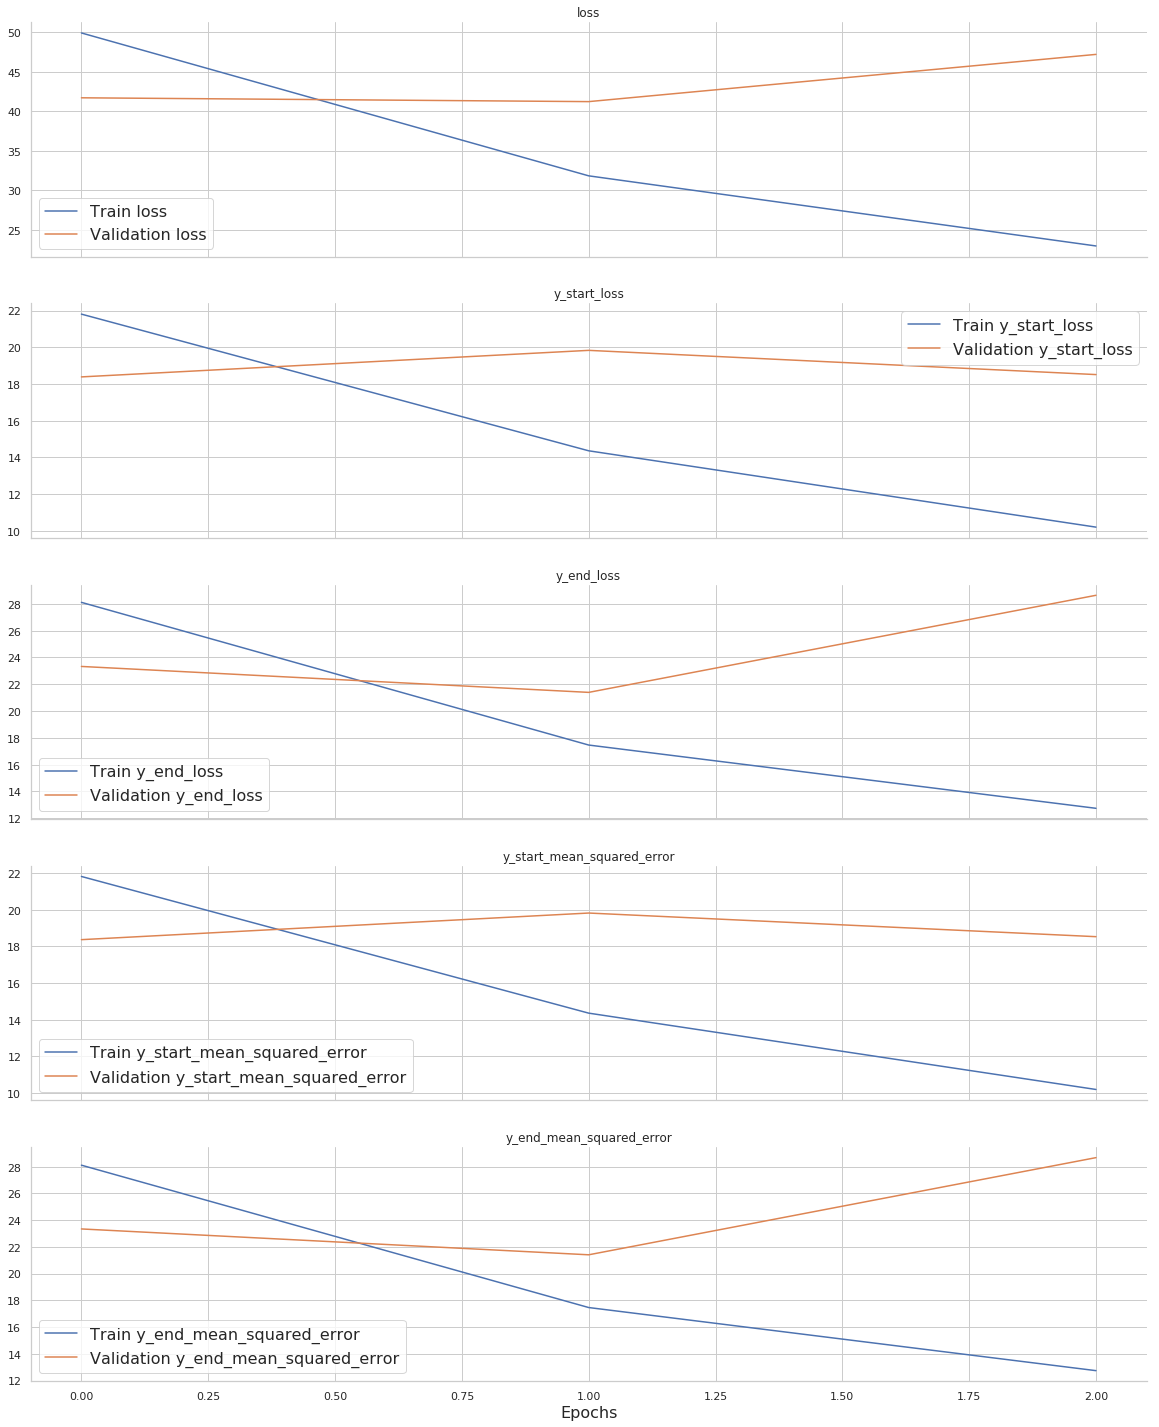

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 
                                       'y_start_mean_squared_error', 'y_end_mean_squared_error'])

# Model evaluation

In [9]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3
Metric/Jaccard,,,,,,,,,
Overall,0.455459,0.442494,0.0129649,0.39252,0.385456,0.502694,0.485038,0.471163,0.456988
Sentiment neutral,0.704056,0.710565,-0.0065081,0.557413,0.562828,0.82676,0.826685,0.727996,0.742181
Sentiment negative,0.294187,0.265089,0.0290975,0.284731,0.273241,0.290413,0.258329,0.307416,0.263697
Sentiment positive,0.279666,0.256022,0.0236443,0.276675,0.257329,0.27542,0.247823,0.286905,0.262914
0 <= text < 10,0.384919,0.370786,0.0141335,0.360561,0.329268,0.510526,0.553459,0.28367,0.22963
10 <= text < 50,0.495679,0.487689,0.00799013,0.415153,0.40461,0.544762,0.543572,0.527122,0.514884
50 <= text < 100,0.445427,0.437922,0.00750519,0.384952,0.376428,0.494021,0.468849,0.457309,0.468489
100 <= text < 200,0.413889,0.385678,0.0282114,0.372575,0.372945,0.452581,0.424594,0.416512,0.359494
0 <= selected text < 10,0.196814,0.178598,0.0182158,0.187567,0.173391,0.189582,0.174019,0.213293,0.188384


# Visualize predictions

In [10]:
display(k_fold.head(15))

,textID,text,selected_text,sentiment,text_len,selected_text_len,fold_1,fold_2,fold_3,fold_4,fold_5,start_fold_1,end_fold_1,prediction_fold_1,start_fold_2,end_fold_2,prediction_fold_2,start_fold_3,end_fold_3,prediction_fold_3
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,36,35,train,train,train,validation,train,3,13,"i`d have responded, if i were going",3,12,"i`d have responded, if i were",3,11,"i`d have responded, if i"
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,46,8,validation,train,train,train,train,4,7,sooo sad i,5,9,o sad i will miss,4,8,sooo sad i will
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,train,validation,train,train,train,5,8,boss is bullying me,7,9,bullying me.,5,8,boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,14,train,validation,train,train,train,4,9,what interview! leave me alone,5,8,interview! leave me,6,9,! leave me alone
4,358bd9e861,"sons of ****, why couldn`t they put them on t...","sons of ****,",negative,75,13,train,train,validation,train,train,6,10,"****,",7,13,"***, why couldn`",7,12,"***, why couldn"
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,92,92,train,train,train,validation,train,12,33,,9,31,.dothebouncy.com/smf - some shameless plugging...,10,35,dothebouncy.com/smf - some shameless plugging ...
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,64,3,train,train,train,train,validation,9,13,the baby are fun when,10,14,baby are fun when he,9,12,the baby are fun
7,50e14c0bb8,soooo high,soooo high,neutral,10,10,train,train,train,train,validation,3,7,,4,6,soooo high,3,4,soo
8,e050245fbd,both of you,both of you,neutral,12,11,train,validation,train,train,train,3,7,,4,5,both of,4,4,both
9,fc2cbefa9d,journey!? wow... u just became cooler. hehe....,wow... u just became cooler.,positive,69,28,train,validation,train,train,train,7,12,wow... u just,11,16,u just became cooler. he,10,15,. u just became cooler.
